In [1]:
import os
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm
from glob import glob
from IPython.display import clear_output
from matplotlib.collections import LineCollection

import sys
sys.path.append('../../Data/auxiliary/')
from img_path import img_files

In [2]:
def replace_special_char(string):
    changes = [('á', 'a'), ('à', 'a'), ('â', 'a'), ('ã', 'a'),
               ('é', 'e'), ('ê', 'e'), ('í', 'i'), ('ó', 'o'),
               ('ô', 'o'), ('õ', 'o'), ('ú', 'u'), ('ç', 'c')]
    
    for change in changes: string = string.replace(change[0], change[1])
    return string

In [3]:
def get_players_history():
    for file in sorted(glob('../../Data/results/processed/*_squads.json')):
        year = int(file[-16:-12])
        if year == 2025: continue
        championship = file.split('/')[-1][:-17]
        filename = f'../auxiliary/players_history_{championship}_{year}.csv'
        if os.path.exists(filename):
            print(f'{filename} already exists')
            continue
        
        print(championship, year)
        players_history = pd.DataFrame(columns=['Player', 'Club', 'Championship', 'Date'])
        with open(file, 'rb') as f: data = json.load(f)
        for game in tqdm(data):
            for sub_game in data[game]:
                if sub_game == 'Summary':
                    home_club = data[game][sub_game]['Home']
                    away_club = data[game][sub_game]['Away']
                    date = data[game][sub_game]['Date']
                    continue
                
                home_squad = set(data[game][sub_game]['Home']['Squad'])
                away_squad = set(data[game][sub_game]['Away']['Squad'])
                for player in home_squad: players_history.loc[len(players_history)] = [player, home_club, championship, date]
                for player in away_squad: players_history.loc[len(players_history)] = [player, away_club, championship, date]
        
        players_history.drop_duplicates(inplace=True)
        players_history.to_csv(filename, index=False)
        clear_output()


In [4]:
get_players_history()
clear_output()

df = pd.DataFrame()
for file in glob('../auxiliary/players_history_*.csv'):
    players_history = pd.read_csv(file)
    df = pd.concat([df, players_history], ignore_index=True)

df = df[df['Player'] >= 100000]
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.sort_values(by=['Player', 'Date'], inplace=True, ignore_index=True)
first_division_clubs = df[(df['Championship'] == 'Serie_A') & (df['Date'] >= '2024-01-01')]['Club'].unique()
first_division_clubs = sorted(first_division_clubs, key=lambda x : (x[-2:], x[:-4]))

df['Last_Club'] = df.groupby('Player')['Club'].shift(1)
df['Last_Club'] = df['Last_Club'].combine_first(df['Club'])
df['Last_Championship'] = df.groupby('Player')['Championship'].shift(1)
df['Last_Date'] = df.groupby('Player')['Date'].shift(1)
df = df[(df['Club'].isin(first_division_clubs)) & (df['Last_Club'].isin(first_division_clubs))]
df['diff_date'] = (df['Date'] - df['Last_Date']).dt.days
df['consider'] = df['diff_date'] <= 180
# df = df[df['Championship'] == 'Serie_A']

clubs_map = dict()
for club1 in first_division_clubs:
    clubs_map[club1] = dict()
    for club2 in first_division_clubs:
        clubs_map[club1][club2] = set()

for index, row in df.iterrows():
    if row['consider']: clubs_map[row['Last_Club']][row['Club']].add(row['Player'])
    clubs_map[row['Club']][row['Club']].add(row['Player'])

for club1 in clubs_map:
    for club2 in clubs_map[club1]:
        clubs_map[club1][club2] = len(clubs_map[club1][club2])

clubs_inx = dict()
for i, club in enumerate(first_division_clubs): clubs_inx[club] = i
inx_clubs = {value: key for key, value in clubs_inx.items()}

In [5]:
max_transfers = 0
for club1 in clubs_map:
    for club2 in clubs_map[club1]:
        if club1 == club2: continue
        tranfers = clubs_map[club1][club2]
        if tranfers > max_transfers:
            max_transfers = tranfers

In [6]:
def create_digraph(clubs_map, clubs_inx, max_nodes=None):
    if max_nodes is None: max_nodes = len(clubs_map) - 1
    
    table = np.zeros((len(clubs_map), len(clubs_map)), dtype=int)
    for club1 in clubs_map:
        i = clubs_inx[club1]
        total_edges = 0
        transfer_threshold = sorted(clubs_map[club1].values(), reverse=True)[max_nodes]
        for club2 in clubs_map:
            j = clubs_inx[club2]
            transfers = clubs_map[club1][club2]
            if club1 == club2:
                table[i, j] = transfers
                continue

            if (transfers >= transfer_threshold and total_edges < max_nodes):
                table[i, j] = transfers
                total_edges += 1

    G = nx.DiGraph(edge_layout='curved')
    for club in clubs_inx:
        i = clubs_inx[club]
        G.add_node(i, color='white', weight=table[i][i])

    for club1 in clubs_inx:
        i = clubs_inx[club1]
        for club2 in clubs_inx:
            if club1 == club2: continue
            j = clubs_inx[club2]
            transfers = table[i][j]
            G.add_edge(i, j, color='lightskyblue', width=transfers, weight=transfers)

    return G

In [7]:
def plot_graph(G, comunidades, inx_clubs, save_fig=False, year=2024, tag=''):
    fig, ax = plt.subplots(figsize=(50, 50))
    
    n_comunidades = len(comunidades)
    pos_comunidades = nx.circular_layout(range(n_comunidades), scale=5.0)
    
    posicoes = {}
    for i, comunidade in enumerate(comunidades):
        center = pos_comunidades[i]
        pos_comunidade = nx.circular_layout(comunidade, scale=3.0)
        
        for node in comunidade:
            posicoes[node] = pos_comunidade[node] + center

    nx.draw_networkx_edge_labels(G,
                                 posicoes,
                                 edge_labels=nx.get_edge_attributes(G, 'relation'),
                                 label_pos=1.5,
                                 font_size=9,
                                 font_color='red',
                                 font_family='sans-serif',
                                 font_weight='normal',
                                 alpha=1.0,
                                 bbox=None,
                                 ax=ax,
                                 rotate=True
                                )

    nx.draw_networkx_nodes(G,
                          pos=posicoes,
                          ax=ax,
                          node_color=[nx.get_node_attributes(G, 'color').get(g, 'steelblue') for g in G.nodes()],
                          node_size=[nx.get_node_attributes(G, 'weight').get(g, 1) * 10 for g in G.nodes()]
                         )
    
    for edge in G.edges():
        start_pos = posicoes[edge[0]]
        end_pos = posicoes[edge[1]]
        
        mid_x = (start_pos[0] + end_pos[0]) / 2
        mid_y = (start_pos[1] + end_pos[1]) / 2
        dx = end_pos[1] - start_pos[1]
        dy = start_pos[0] - end_pos[0]
        control_x = mid_x + 0.2 * dx
        control_y = mid_y + 0.2 * dy
        
        t = np.linspace(0, 1, 100)
        x = (1-t)**2 * start_pos[0] + 2*(1-t)*t * control_x + t**2 * end_pos[0]
        y = (1-t)**2 * start_pos[1] + 2*(1-t)*t * control_y + t**2 * end_pos[1]
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        colors = np.zeros((99, 4))
        # colors[:, 0] = np.linspace(0, 1, 99)
        # colors[:, 1] = np.linspace(249 / 255, 38 / 255, 99)
        colors[:, 0] = 70 / 255
        colors[:, 1] = 130 / 255
        colors[:, 2] = 180 / 255
        colors[:, 3] = np.linspace(1, 0.25, 99)
        
        lc = LineCollection(segments, colors=colors, linewidth=nx.get_edge_attributes(G, 'width').get(edge, 1) * 2)
        ax.add_collection(lc)

    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform
    weights = nx.get_node_attributes(G, 'weight')
    
    w_max = max(weights.values(), default=1)
    w_min = min(weights.values(), default=1)
    dif = w_max - w_min

    for g in G.nodes():
        node = replace_special_char(inx_clubs[g]).replace(' ', '')
        img = mpimg.imread('../../' + img_files[node])
        weight = nx.get_node_attributes(G, 'weight').get(g, 1)
        imsize = (weight - w_min) / dif * 0.03 + 0.02 if dif else 0.02
        (x, y) = posicoes[g]
        xx, yy = trans((x, y))
        xa, ya = trans2((xx, yy))
        a = plt.axes([xa - imsize / 2, ya - imsize / 2, imsize, imsize])
        a.imshow(img)
        a.set_aspect('equal')
        a.axis('off')

    if save_fig:
        plt.savefig(f'../figures/clubs_connectivity_{year}{tag}.png')


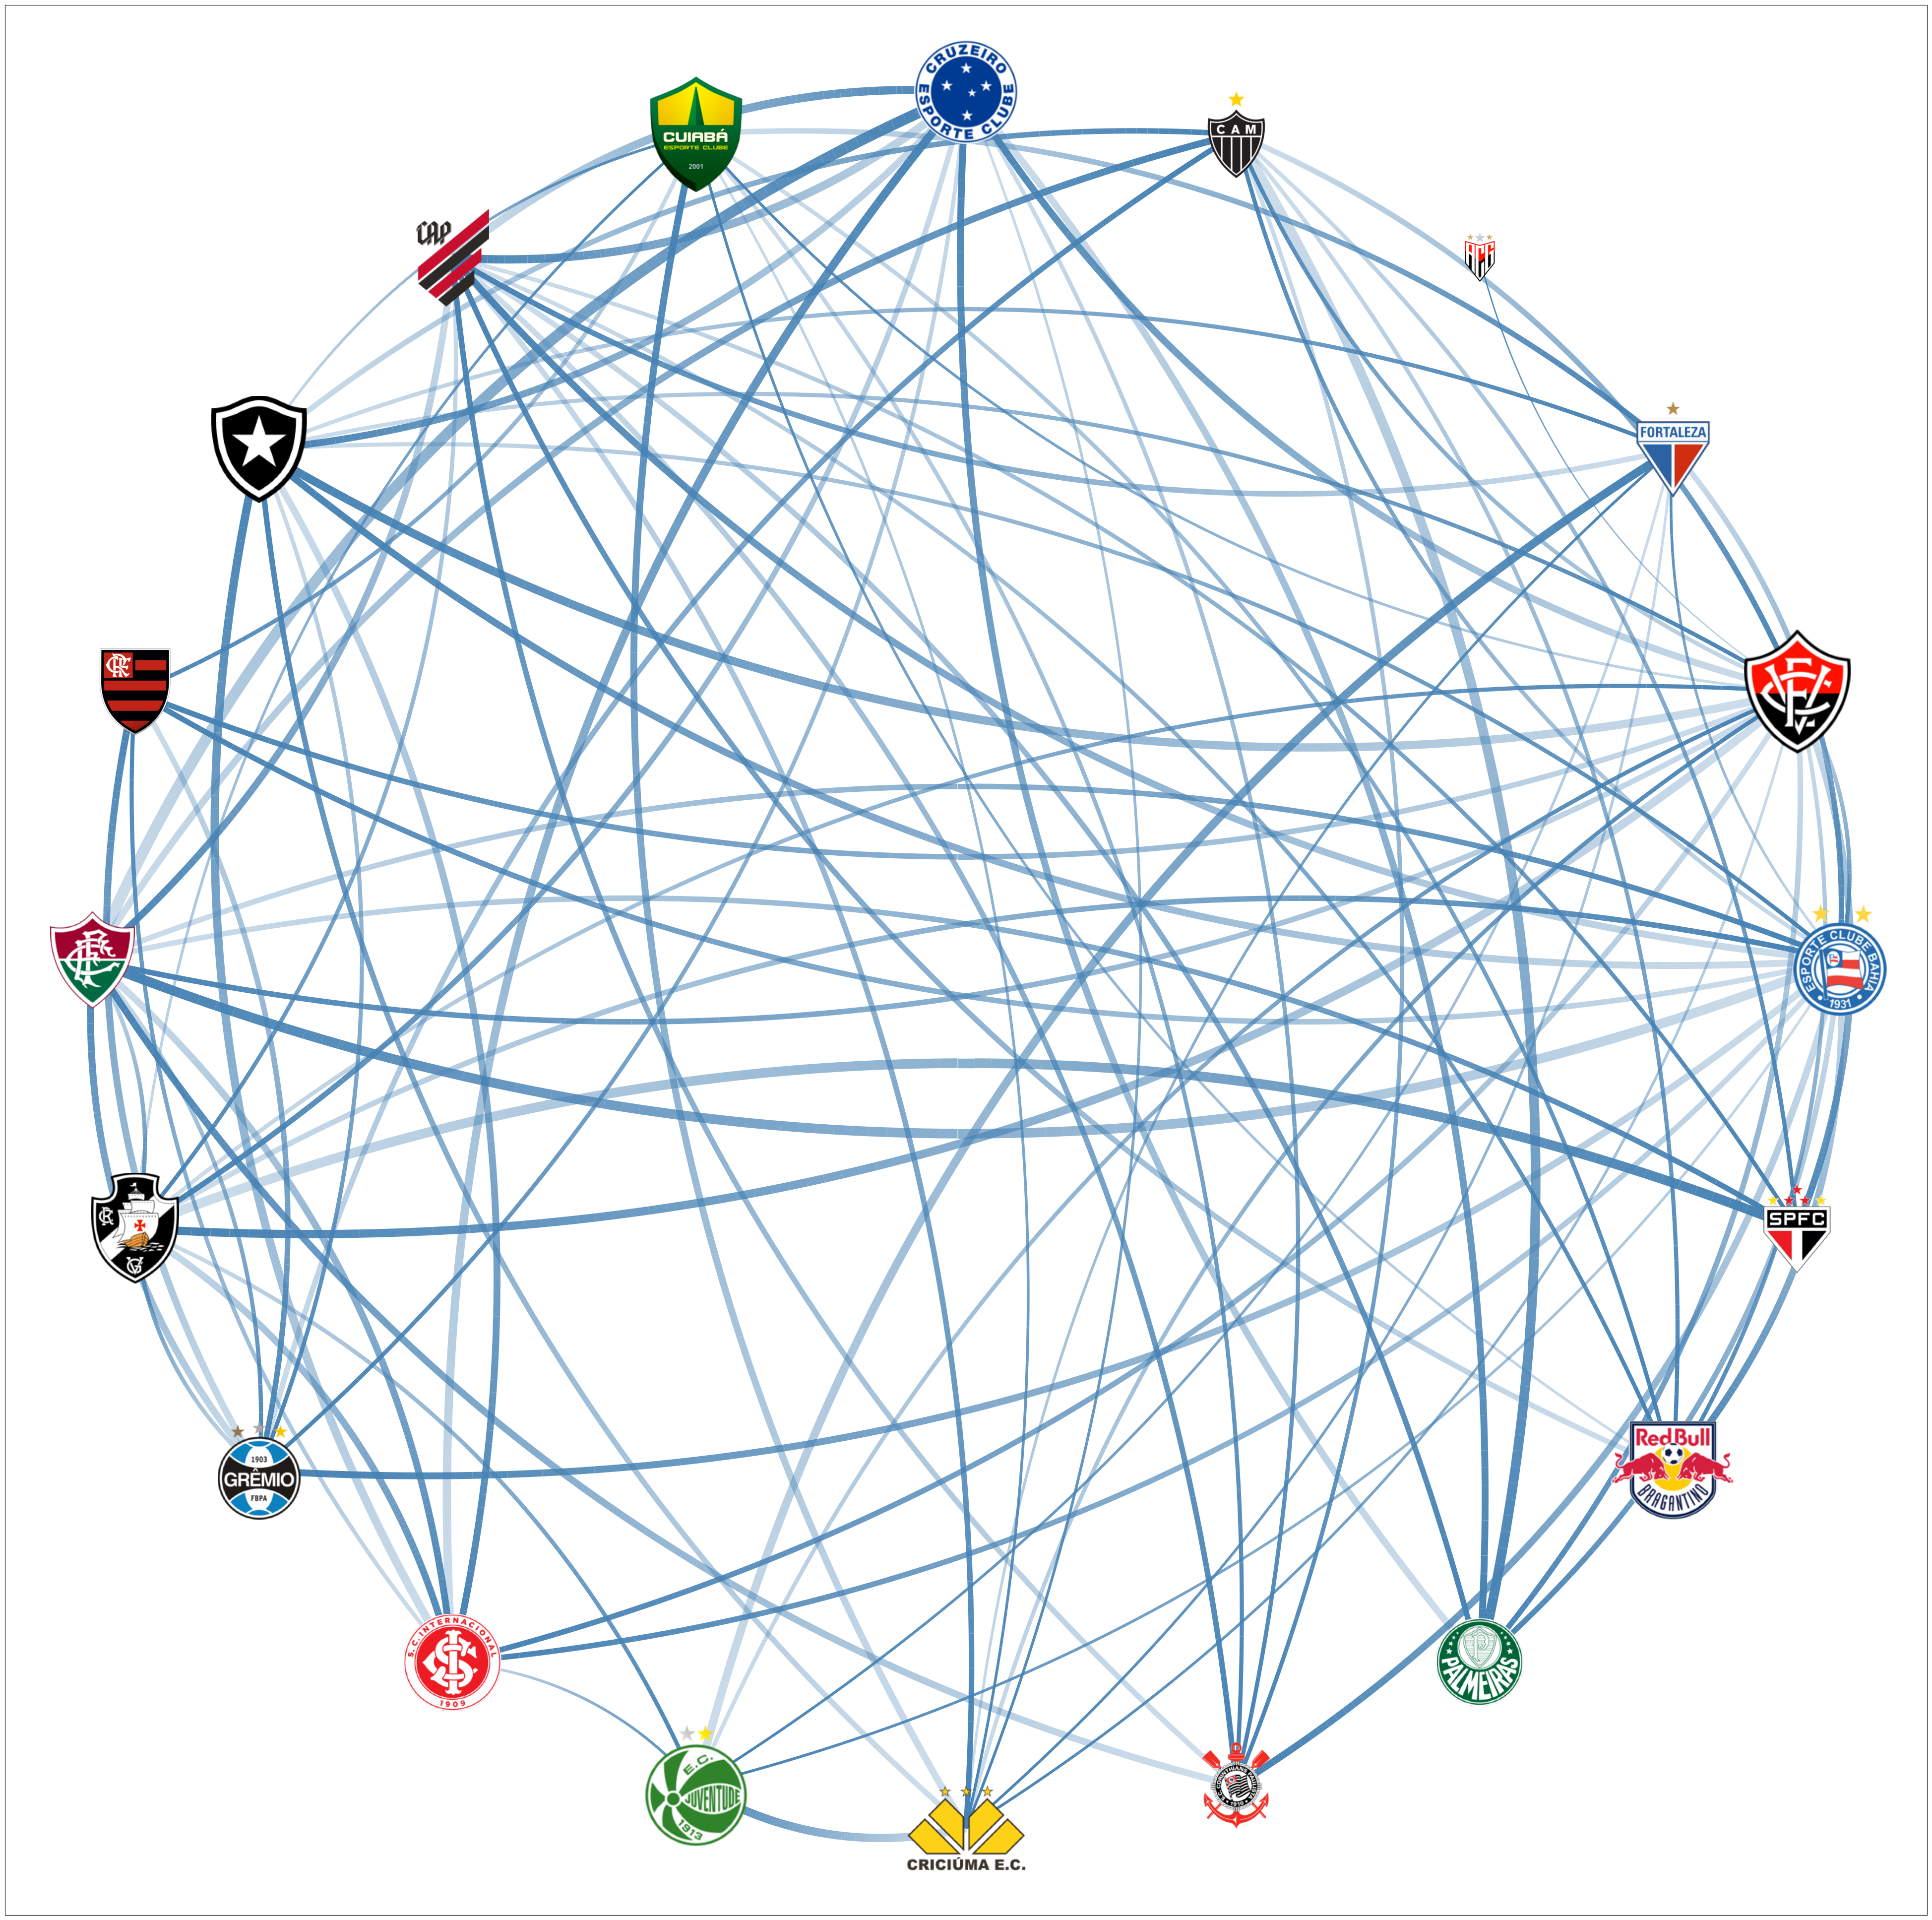

In [8]:
G = create_digraph(clubs_map, clubs_inx, max_nodes=5)
communities = nx.community.greedy_modularity_communities(G, weight='weight')

com = set()
for c in communities: com = com.union(c)
com = [frozenset(com)]

plot_graph(G, com, inx_clubs, save_fig=True, year=2024, tag='_direct_transfers')